#**Acquisition and Reconstruction**
###Assignment 2 : Shepp Logan phantom and 3D surface extraction

The goal of this assignment is to to extract surfaces from a pre-segmented phantom image. This phantom is the famous Shepp Logan phantom (https://en.wikipedia.org/wiki/Shepp%E2%80%93Logan_phantom).

The file format of this pre-segmented phantom is PGM3D. This is an extension of the common PGM format.

The header is as follow :

    l0      PGM3D    #keyword to identify the file format

    l1      x y z    #size of the 3D image
    
    l2      max      #maximum greylevel
    
    l3-end  DATA     #x*y*z grey values 
    
The three firsts lines represent the header of the file, and from line 4 to the end are the data, one value by line.

You can find the PGM3D file here : http://dept-info.labri.fr/~desbarat/ARM/shepplogan.pgm3d .

You can also use the code below to install the needed libraries and download the file in the current working directory :

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import subprocess
import pkg_resources

required = {'wget', 'numpy', 'matplotlib', 'plotly', 'nbformat'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', *missing], stdout=None)

In [3]:
import wget

wget.download("http://dept-info.labri.fr/~desbarat/ARM/shepplogan.pgm3d")

'shepplogan.pgm3d'

Use the snippet below to import the needed libraries (Numpy for array manipulation, matplotlib for 2D plot and plotly for 3D plot) :

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

### **Performances** (2pts)
For this assignment, two points are dedicated to the performance of your implementation. Avoid using nested for loop as mush as possible, and use Numpy function and broadcast operator when possible. 

### **Reading the PGM3D file** (5pts)

Step 1.1. Using the python standard libraries, read the content of the pgm3d file, split it by lines and check that the first one is correct. (1pts)

In [5]:
f = open('shepplogan.pgm3d')
content = f.read()
content_list = content.splitlines()
f.close()
print(content_list[0])

PGM3D


Step 1.2. Collect the data from the header : Width, height, depth and max value. (1pts)

In [6]:
V = int(content_list[2]) #Max Value

shape = content_list[1].split(" ")
width = int(shape[0])
height = int(shape[1])
depth = int(shape[2])



Step 1.3. Put the data values in a 3D numpy array. You should first allocate the array : avoid using append or similar functions, it would be really slow. (1pts)

In [7]:

v = content_list[3:width*height*depth+3]
v = [int(g) for g in v]

voxels = np.zeros(width*height*depth)
voxels = np.asarray(v)
voxels = voxels.reshape([width,height,depth])



Step 1.4. Display the middle slice of the volume for all three axis (Coronal, Sagittal, Horizontal) using matplotlib. (2pts)

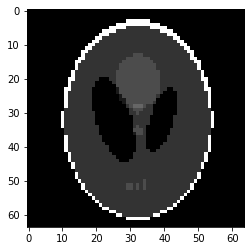

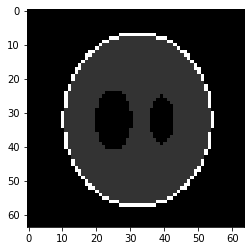

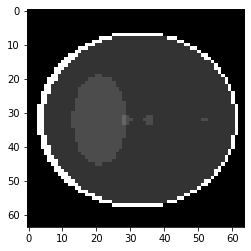

In [8]:

im1 = voxels[int(width/2),:,:]
im2 = voxels[:,int(height/2),:]
im3 = voxels[:,:,int(depth/2)]

plt.imshow(im1, cmap= plt.cm.gray)
plt.show()

plt.imshow(im2, cmap= plt.cm.gray)
plt.show()

plt.imshow(im3, cmap= plt.cm.gray)
plt.show()

###**Creating a 3d mesh (8pts)**
You will now transform the 3D array into a surface mesh. A mesh is a collection of polygons (in our case, triangles), composed of vertices and faces.

A common way to store a mesh is to build two arrays. The first one store the vertices position, of size 3-by-N, with N the number of vertices : 

```
<vertex0.x> <vertex0.x> <vertex0.x> <vertex1.y> <vertex1.y> <vertex1.y> <vertex2.x> ...
```

The second one store the faces. Each faces is composed of 3 vertices, represented by their respective index in the vertices list. This array should of integer type.

```
<vertex_id1_face0> <vertex_id2_face0> <vertex_id2_face0> <vertex_id0_face1> ...
```

To transform a voxelized volume into a mesh, you will need to create the surface between each region of different values.
So, for each voxels, check its 6 neighboor, and when one is different, create the face between them (or faces, since a square is composed of two triangle).

Step 2.1. Create an array of vertices, and one of faces, that represent a cube of size 1x1x1. (2pts)

Try to do it yourself without taking the values on the internet, to learn how to do it ! 

In [9]:
cube_vertices = np.array([[0,0,0], [0,0,1], [0,1,0], [1,0,0], [0,1,1], [1,0,1], [1,1,0], [1,1,1]]).flatten()


cube_faces = np.array([[0,1,3], [1,5,3], [0,1,2], [1,2,4], [2,4,6], [4,6,7], [3,5,6], [5,6,7],[1,4,5], [4,5,7], [0,2,3], [2,3,6]], dtype=np.int32).flatten()

#[0,1,2], [1,2,4],[2,4,6], [4,6,7], [3,5,6], [5,6,7], [1,4,5], [4,5,7], [0,2,3], [2,3,6]

Step 2.2. Start the code below. If your vertices and faces are correct. It should display the cube. You can try to remove some faces and see the result to be sure that you know the position of each faces in the array.

In [10]:
fig = go.Figure(data=[
    go.Mesh3d(
        x=cube_vertices[0::3],
        y=cube_vertices[1::3],
        z=cube_vertices[2::3],
        color = 'rgb(200, 50, 50)',
        opacity = 0.75,
        i = cube_faces[0::3],
        j = cube_faces[1::3],
        k = cube_faces[2::3],
        showscale=True
    )
])

fig.show()

Step 2.3. The code below will create a new data array exaclty half the size of the full one. From this point, you will use this array in order to avoid long computations.

In [22]:
hData = voxels[0::2, 0::2, 0::2]
hX = width//2
hY = height//2
hZ = depth//2

Step 2.4. Now, iterate over the voxels of hData, and fill 'faces_list' and 'vertices_list' to create the mesh that separate all voxels of different values. 
Tips : each 'border' between two region will be processed twice : you can only check three neighboors instead of six to avoid duplicated faces. (6pts)

In [23]:


faces_list = np.array([], dtype=np.int32)
vertices_list = np.array([], dtype=np.float32)
n = 0
for i in range(1,hX) :
  for j in range(1,hY) :
    for w in range(1, hZ):
      if hData[i,j,w] != hData[i-1, j, w]: #we test the voxel on the left
        vertices_list = np.append(vertices_list, [i,j,w,i,j,w+1,i,j+1,w+1,i,j+1,w]) #Each vertices has 3 coordinates, and we have 4 vertices for an interface between two voxels
        faces_list = np.append(faces_list, [n,n+1,n+2,n,n+2,n+3])                   #Each faces needs 3 vertices, and for an interface between two voxels, we need 2 faces
        n = n+4

      if hData[i,j,w] != hData[i, j-1, w]: #we test the voxel above 
        vertices_list = np.append(vertices_list, [i,j,w,i,j,w+1,i+1,j,w+1,i+1,j,w])
        faces_list = np.append(faces_list, [n,n+1,n+2,n,n+2,n+3])
        n = n+4

      if hData[i,j,w] != hData[i,j,w-1]: #we test the voxel before
        vertices_list = np.append(vertices_list, [i,j,w,i+1,j,w,i+1,j+1,w,i,j+1,w])
        faces_list = np.append(faces_list, [n,n+1,n+2,n,n+2,n+3])
        n = n+4



Step 2.5. The snippet below will display the result of your faces_list and vertices_list.

In [24]:
fig = go.Figure(data=[
    go.Mesh3d(
        x=vertices_list[0::3],
        y=vertices_list[1::3],
        z=vertices_list[2::3],
        color = 'rgb(150, 150, 150)',
        opacity = 0.3,
        i = faces_list[0::3],
        j = faces_list[1::3],
        k = faces_list[2::3],
        showscale=True
    )
])
fig.show()

###**Segmenting the mesh (5pts)**

Step 3.1. Now, do the same thing as before but separate each region into its own mesh. To do so, store the faces and vertices in an array corresponding to the current region value. You will now need to check all neighboor this time. (5pts)

In [20]:
faces_list = [np.array([], dtype=np.int32)]*(V+1)
vertices_list = [np.array([], dtype=np.float32)]*(V+1)

n = np.zeros(256, dtype= int) #number of vertices for each sub-meshes
for i in range(1,hX-1) :
  for j in range(1,hY-1) :
    for w in range(1, hZ-1):
      k = hData[i,j,w]   #color of the pixel we test
      if hData[i,j,w] != hData[i-1, j, w]: #we test the pixel on the left
        vertices_list[k] = np.append(vertices_list[k], [i,j,w,i,j,w+1,i,j+1,w+1,i,j+1,w])
        faces_list[k] = np.append(faces_list[k], [n[k],n[k]+1,n[k]+2,n[k],n[k]+2,n[k]+3])
        n[k] = n[k]+4

      if hData[i,j,w] != hData[i+1, j, w]: #we test the pixel on the right
        vertices_list[k] = np.append(vertices_list[k], [i+1,j,w,i+1,j,w+1,i+1,j+1,w+1,i+1,j+1,w])
        faces_list[k] = np.append(faces_list[k], [n[k],n[k]+1,n[k]+2,n[k],n[k]+2,n[k]+3])
        n[k] = n[k]+4

      if hData[i,j,w] != hData[i, j-1, w]: #we test the pixel above
        vertices_list[k] = np.append(vertices_list[k], [i,j,w,i,j,w+1,i+1,j,w+1,i+1,j,w])
        faces_list[k] = np.append(faces_list[k], [n[k],n[k]+1,n[k]+2,n[k],n[k]+2,n[k]+3])
        n[k] = n[k]+4

      if hData[i,j,w] != hData[i, j+1, w]: #we test the pixel under
        vertices_list[k] = np.append(vertices_list[k], [i,j+1,w,i,j+1,w+1,i+1,j+1,w+1,i+1,j+1,w])
        faces_list[k] = np.append(faces_list[k], [n[k],n[k]+1,n[k]+2,n[k],n[k]+2,n[k]+3])
        n[k] = n[k]+4

      if hData[i,j,w] != hData[i,j,w-1]: #we test the pixel ahead
        vertices_list[k] = np.append(vertices_list[k], [i,j,w,i+1,j,w,i+1,j+1,w,i,j+1,w])
        faces_list[k] = np.append(faces_list[k], [n[k],n[k]+1,n[k]+2,n[k],n[k]+2,n[k]+3])
        n[k] = n[k]+4

      if hData[i,j,w] != hData[i,j,w-1]: #we test the pixel back
        vertices_list[k] = np.append(vertices_list[k], [i,j,w+1,i+1,j,w+1,i+1,j+1,w+1,i,j+1,w+1])
        faces_list[k] = np.append(faces_list[k], [n[k],n[k]+1,n[k]+2,n[k],n[k]+2,n[k]+3])
        n[k] = n[k]+4


faces_list = list(filter(lambda x: len(x) > 0, faces_list)) #We keep only the non-empty arrays
vertices_list = list(filter(lambda x: len(x) > 0, vertices_list))
print("Number of sub-meshes :", len(faces_list))


Number of sub-meshes : 6


Step 3.2. The code below will display each mesh in your lists

In [21]:

for i in range(len(faces_list)):

  fig = go.Figure(data=[
    go.Mesh3d(
        x=vertices_list[i][0::3],
        y=vertices_list[i][1::3],
        z=vertices_list[i][2::3],
        color = 'rgb(120, 120, 120)',
        opacity = 0.3,
        i = faces_list[i][0::3],
        j = faces_list[i][1::3],
        k = faces_list[i][2::3],
        showscale=True
    )
  ])
  fig.show()

###**Exporting an OBJ file (bonus)**

4.2. The OBJ file format allow to describe a 3D mesh from a list of vertices and how they are linked to create faces.

It's an ASCII file format that can be resumed as such :

    #List of all vertices

    v x1 y1 z1

    v x2 y2 z2

    v x3 y3 z3

    #List of all faces

    f 1 2 3

This create 3 vertices that are linked together to create one face.

Step 1. Write the code necessary to create an OBJ file that contains a mesh from the previous section You can vizualize your OBJ file using meshlab : https://www.meshlab.net/ (already installed on CREMI machines)

In [16]:
f = open("mesh.obj", "w")

print("#List of all vertices \r", file = f)
print("\r", file = f)

k = 0

for i in range(int(vertices_list[k].size/3)): # All vertices have 3 coordinates, so the number of vertices is vertices_list/3
  print("v " + str(vertices_list[k][i*3]) + " " + str(vertices_list[k][i*3 + 1]) + " " + str(vertices_list[k][i*3 + 2]) + "\r", file = f)
  print("\r", file = f)

print("#List of all faces \r", file = f)
print("\r", file = f)

for i in range(int(faces_list[k].size/3)): # Same remark that for the vertices
  print("f " + str(faces_list[k][i*3]) + " " + str(faces_list[k][i*3 + 1]) + " " + str(faces_list[k][i*3 + 2])+ "\r\r", file = f)
  print("\r", file = f)

f.close()